In [2]:
import pandas as pd
import os
import numpy as np
from scipy import signal

def filter_signal(dat:np.ndarray, 
                  band=[1,40], 
                  sampling_rate:int=500):
    # data: 1D array
    [b, a] = signal.iirnotch(60, 30, sampling_rate) # power noise
    dat = signal.filtfilt(b, a, dat)
    [b, a] = signal.butter(3, band, 'bandpass', fs=sampling_rate)
    dat = signal.filtfilt(b, a, dat)
    # dat =  np.convolve(dat, np.ones(sampling_rate//20) / (sampling_rate//20), mode='same')
    return dat

def organize_emotion_data(easy_, resample_fs=125):
    sig = np.zeros((9,10,500*120))
    easy = easy_[:,1::2]
    event = np.where(easy[8]!=0)[0]
    if len(event) < 2:
        easy = easy_[:,0::2]
        event = np.where(easy[8]!=0)[0]
    if len(event) != 9:
        event = event[1:]
    event = np.stack((event, easy[8,event]), 1)
    easy = filter_signal(easy)
    sig[0] = np.concatenate((easy[:,event[0,0]:event[0,0]+500*60], easy[:,event[0,0]+500*65:event[0,0]+500*125]), axis=1)
    for num_trial in range(1, 9):
        sig[num_trial] = easy[:,event[num_trial,0]:event[num_trial,0]+500*120]
    sig = signal.resample(sig, resample_fs*120, axis=2)
    return sig[:,:8] #, event[:,1]

def load_emotion_data():
    ROOT_PATH = r'D:/One_한양대학교/private object minsu/coding/data/samsung_2024/Day 1/'
    fs = 125
    subj_list = os.listdir(ROOT_PATH)
    print(subj_list)

    emotion_data = np.zeros((len(subj_list), 9, 8, fs*120))
    emotion_label = np.zeros((len(subj_list), 9, 2))
    emotion_label2 = np.zeros((len(subj_list), 9))
    for idx, subj in enumerate(subj_list):
        dat_list = os.listdir(ROOT_PATH+subj)
        # print(subj, dat_list[0])

        easy = np.asarray(pd.read_csv(ROOT_PATH + subj + '/' + dat_list[0], delimiter='\t')).T
        emotion_data[idx] = organize_emotion_data(easy, fs)

        label_raw = pd.read_csv(ROOT_PATH + subj + '/' + [s for s in dat_list if 'Emotion' in s][0])
        label_np = np.array(label_raw[['resting','H1','H2','P1','P2','A1','A2','S1','S2']])
        label_np[2,0] = -1
        emotion_label[idx] = label_np[:2, np.argsort(label_np[2])].T
        label_2 = np.stack([label_np[2], [0, 1, 1, 2, 2, 3, 3, 4, 4]])
        emotion_label2[idx] = label_2[1, np.argsort(label_2[0])]
    return emotion_data, emotion_label, emotion_label2

emotion_data, emotion_label, emotion_label2 = load_emotion_data()

['02.YBJ', '03.JHS', '04.HJH', '05.LHS', '06,KAY(W)', '07.HSY', '08.KHJ(W)', '09.LGY(W)', '10.PJU', '11.KMJ(W)', '12.KJG(W)', '13.LHJ', '14.YSA', '15.KHI(W)', '16.CHJ(W)', '17.PCG', '18.ASJ(W)', '19.RWO', '20.CYS', '21.HDE(W)', '22.SMS', '23.LHJ', '24.OJM', '25.SJH(W)', '26.HYJ(W)', '27.KTH(W)', '28.JMY(W)', '29.SSJ', '30.KHW', '31.PYJ(W)', '32.JMK(W)', '33.CYR']


In [4]:
np.save('emotion_data.npy',emotion_data)
np.save('emotion_label.npy',emotion_label)
np.save('emotion_label2.npy',emotion_label2)

In [ ]:
"""
emotion_data: shape (32, 9, 8, 15000) = (num_subject, trials, electrode channels, time samples)
    trials (9 trials): resting, happy/peaceful, sad/angry 
    electrode channels (8 channels): Fp(AF7, FPZ, AF8), Central (C3, CZ, C4), Ear (Left, Right) 
    time samples: 125 Hz downsampled, 1-40 Hz bandpass filtered, 60 Hz notch filtered

NOTE: signal for resting state is concatenated signal (60 sec eyes open + 60 sec eyes closed)

emotion_label: shape (32, 9, 2) = (num_subject, trials, emotional state)
    emotional state: idx 0 is for arousal, and idx 1 is for valence. scored 1 to 5.

NOTE: you can transform score label into binary label (pos/neg valence and high/low arousal), as follows:
        new_emotion_label = np.array(emotion_label>2,int)

emotion_label2: shape (32, 9) = (num_subject, trials)
    target emotion is labeled as 1-4. (0: resting, 1: happy, 2: peaceful, 3: angry, 4: sad)
""" 

'\nemotion_data: shape (33, 9, 8, 15000) = (num_subject, trials, electrode channels, time samples)\n    trials (9 trials): resting, happy/peaceful, sad/angry \n    electrode channels (8 channels): Fp(AF7, FPZ, AF8), Central (C3, CZ, C4), Ear (Left, Right) \n    time samples: 125 Hz downsampled, 1-40 Hz bandpass filtered, 60 Hz notch filtered\n\nNOTE: signal for resting state is concatenated signal (60 sec eyes open + 60 sec eyes closed)\n\nemotion_label: shape (33, 9, 2) = (num_subject, trials, emotional state)\n    emotional state: idx 0 is for arousal, and idx 1 is for valence. scored 1 to 5.\n\nNOTE: you can transform score label into binary label (pos/neg valence and high/low arousal), as follows:\n        new_emotion_label = np.array(emotion_label>2,int)\n'

In [37]:
import pandas as pd
import os
import numpy as np
from scipy import signal
from mne.filter import resample

def filter_signal(dat:np.ndarray, 
                  band=[1,40], 
                  sampling_rate:int=500):
    # data: 1D array
    [b, a] = signal.iirnotch(60, 30, sampling_rate) # power noise
    dat = signal.filtfilt(b, a, dat)
    [b, a] = signal.butter(3, band, 'bandpass', fs=sampling_rate)
    dat = signal.filtfilt(b, a, dat)
    # dat =  np.convolve(dat, np.ones(sampling_rate//20) / (sampling_rate//20), mode='same')
    return dat

def preprocess_emotion_data(path:str, fs:int=125):
    ROOT_PATH = path + '/Day 1/'
    subj_list = os.listdir(ROOT_PATH)
    print(subj_list)

    eeg_resting = []
    eeg = []
    eeg_washoff = []
    label_rating = []
    label_target = []

    for idx, subj in enumerate(subj_list):
        dat_list = os.listdir(ROOT_PATH+subj)
        # print(subj, dat_list[0])
        easy_ = np.asarray(pd.read_csv(ROOT_PATH + subj + '/' + dat_list[0], delimiter='\t'), float).T
        easy = easy_[:,0::2] / 1e3
        event = np.append(np.where(easy[8]!=0)[0], np.where(easy_[8,1::2]!=0)[0])//(500//fs)
        event.sort()
        easy = easy[:8]
        easy = resample(easy, down=500//fs)
        easy = filter_signal(easy, sampling_rate=125)
        eeg_resting.append(np.stack((easy[:,event[0]:event[0]+fs*60], easy[:,event[0]+fs*65:event[0]+fs*125]), axis=0))
        eeg.append(np.stack([easy[:,event[i]:event[i]+fs*120] for i in range(1,9)]))

        temp = []
        for i in range(1, 9):
            mid_point = (event[i] + fs*120 + easy.shape[1])//2 if i == 8 else (event[i] + fs*120 + event[i+1])//2 
            temp.append(easy[:,mid_point-fs*15:mid_point+fs*15])
        eeg_washoff.append(np.stack(temp, 0))

        label_raw = pd.read_csv(ROOT_PATH + subj + '/' + [s for s in dat_list if 'Emotion' in s][0])
        label_np = np.array(label_raw[['resting','H1','H2','P1','P2','A1','A2','S1','S2']])
        label_np[2,0] = -1
        label_rating.append(label_np[:2, np.argsort(label_np[2])].T)
        label_2 = np.stack([label_np[2], [0, 1, 1, 2, 2, 3, 3, 4, 4]])
        label_target.append(label_2[1, np.argsort(label_2[0])])

    eeg = np.stack(eeg, 0)
    eeg_resting = np.stack(eeg_resting, 0)
    eeg_washoff = np.stack(eeg_washoff, 0)
    label_rating = np.stack(label_rating, 0)
    label_target = np.stack(label_target, 0)

    np.savez_compressed(f'{path}/emotion/emotion.npz', 
                        eeg=eeg, 
                        eeg_resting=eeg_resting, 
                        eeg_washoff=eeg_washoff, 
                        label_rating=label_rating, 
                        label_target=label_target)
    
preprocess_emotion_data('D:/One_한양대학교/private object minsu/coding/data/samsung_2024')

['02.YBJ', '03.JHS', '04.HJH', '05.LHS', '06,KAY(W)', '07.HSY', '08.KHJ(W)', '09.LGY(W)', '10.PJU', '11.KMJ(W)', '12.KJG(W)', '13.LHJ', '14.YSA', '15.KHI(W)', '16.CHJ(W)', '17.PCG', '18.ASJ(W)', '19.RWO', '20.CYS', '21.HDE(W)', '22.SMS', '23.LHJ', '24.OJM', '25.SJH(W)', '26.HYJ(W)', '27.KTH(W)', '28.JMY(W)', '29.SSJ', '30.KHW', '31.PYJ(W)', '32.JMK(W)', '33.CYR']


['02.YBJ', '03.JHS', '04.HJH', '05.LHS', '06,KAY(W)', '07.HSY', '08.KHJ(W)', '09.LGY(W)', '10.PJU', '11.KMJ(W)', '12.KJG(W)', '13.LHJ', '14.YSA', '15.KHI(W)', '16.CHJ(W)', '17.PCG', '18.ASJ(W)', '19.RWO', '20.CYS', '21.HDE(W)', '22.SMS', '23.LHJ', '24.OJM', '25.SJH(W)', '26.HYJ(W)', '27.KTH(W)', '28.JMY(W)', '29.SSJ', '30.KHW', '31.PYJ(W)', '32.JMK(W)', '33.CYR']


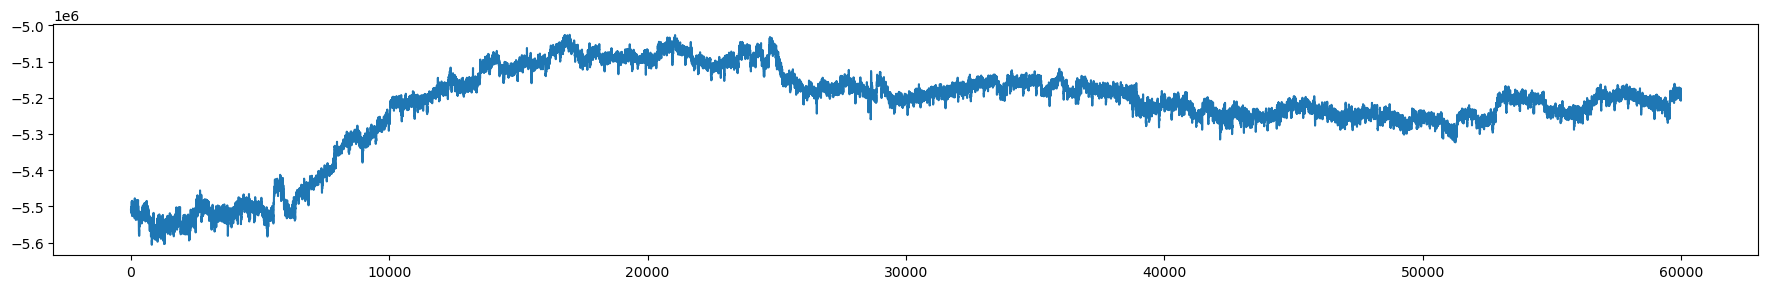

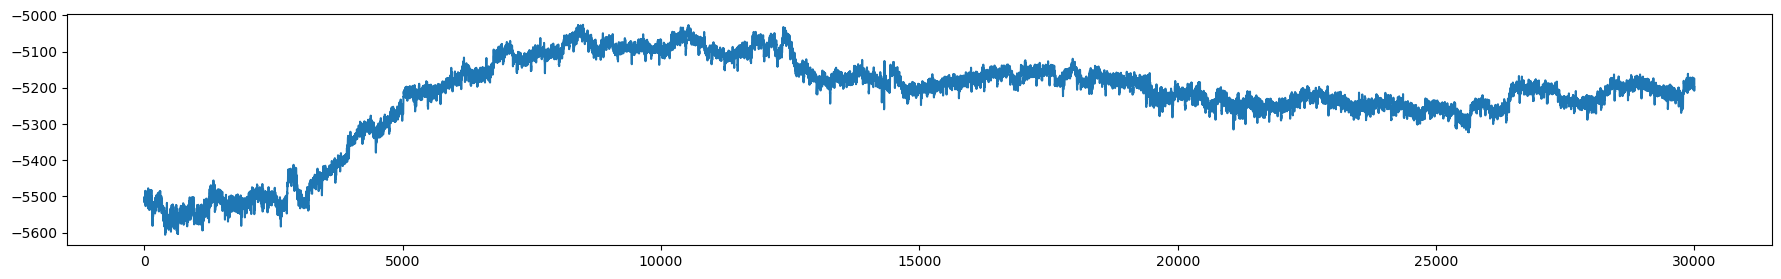

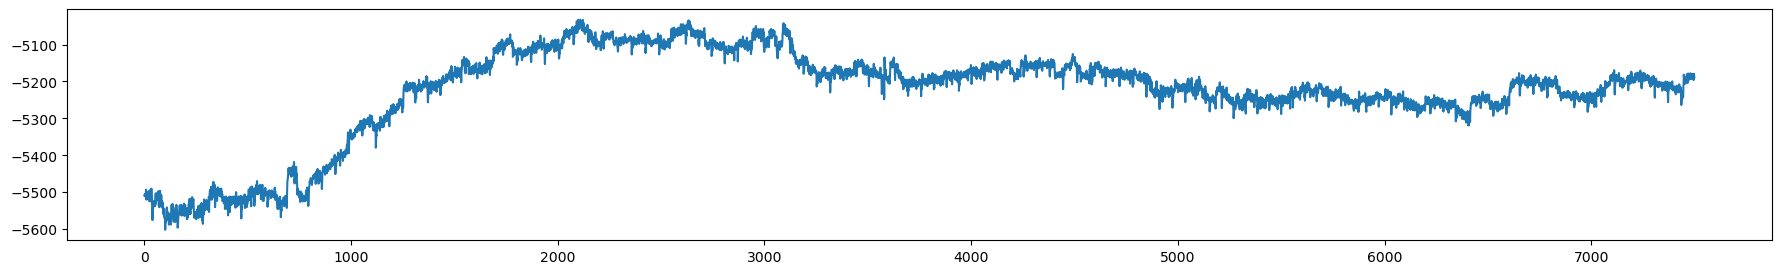

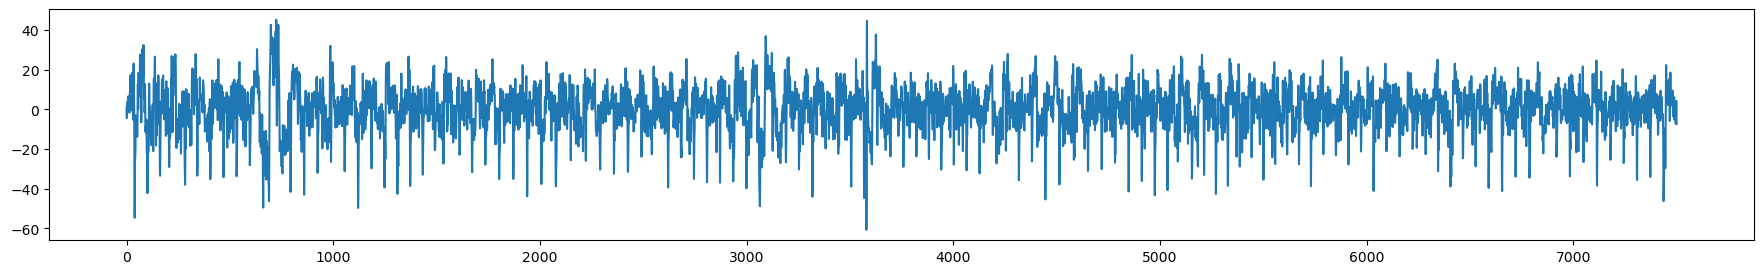

In [42]:
import pandas as pd
import os
import numpy as np
from scipy import signal
from mne.filter import resample
import matplotlib.pyplot as plt

def filter_signal(dat:np.ndarray, 
                  band=[1,40], 
                  sampling_rate:int=500):
    # data: 1D array
    [b, a] = signal.iirnotch(60, 30, sampling_rate) # power noise
    dat = signal.filtfilt(b, a, dat)
    [b, a] = signal.butter(3, band, 'bandpass', fs=sampling_rate)
    dat = signal.filtfilt(b, a, dat)
    # dat =  np.convolve(dat, np.ones(sampling_rate//20) / (sampling_rate//20), mode='same')
    return dat

path = 'D:/One_한양대학교/private object minsu/coding/data/samsung_2024'
fs = 125
ROOT_PATH = path + '/Day 1/'
subj_list = os.listdir(ROOT_PATH)
print(subj_list)

eeg_resting = []
eeg = []
eeg_washoff = []
label_rating = []
label_target = []

subj = subj_list[0]
dat_list = os.listdir(ROOT_PATH+subj)
# print(subj, dat_list[0])
easy_ = np.asarray(pd.read_csv(ROOT_PATH + subj + '/' + dat_list[0], delimiter='\t'), float).T 
easy = easy_[:,0::2] / 1e3
event = np.append(np.where(easy[8]!=0)[0], np.where(easy_[8,1::2]!=0)[0])//(500//fs)
event.sort()
plt.figure(figsize=(22,3))
plt.plot(easy_[7,event[1]*8:event[1]*8+1000*60])
easy = easy[:8]
plt.figure(figsize=(22,3))
plt.plot(easy[7,event[1]*4:event[1]*4+500*60])
easy = resample(easy, down=500//fs)
plt.figure(figsize=(22,3))
plt.plot(easy[7,event[1]:event[1]+125*60])
easy = filter_signal(easy, sampling_rate=125)
plt.figure(figsize=(22,3))
plt.plot(easy[7,event[1]:event[1]+125*60])

# eeg_resting.append(np.stack((easy[:,event[0]:event[0]+fs*60], easy[:,event[0]+fs*65:event[0]+fs*125]), axis=0))
# eeg.append(np.stack([easy[:,event[i]:event[i]+fs*120] for i in range(1,9)]))

temp = []
for i in range(1, 9):
    mid_point = (event[i] + fs*120 + easy.shape[1])//2 if i == 8 else (event[i] + fs*120 + event[i+1])//2 
    temp.append(easy[:,mid_point-fs*15:mid_point+fs*15])
eeg_washoff.append(np.stack(temp, 0))

In [38]:
import numpy as np
mist = np.load('D:/One_한양대학교/private object minsu/coding/data/samsung_2024/emotion/emotion.npz')
print(mist['eeg'].shape)
print(mist['eeg_washoff'].shape)
print(mist['eeg_resting'].shape)
print(mist['label_rating'].shape)
print(mist['label_target'].shape)

(32, 8, 8, 15000)
(32, 8, 8, 3750)
(32, 2, 8, 7500)
(32, 9, 2)
(32, 9)


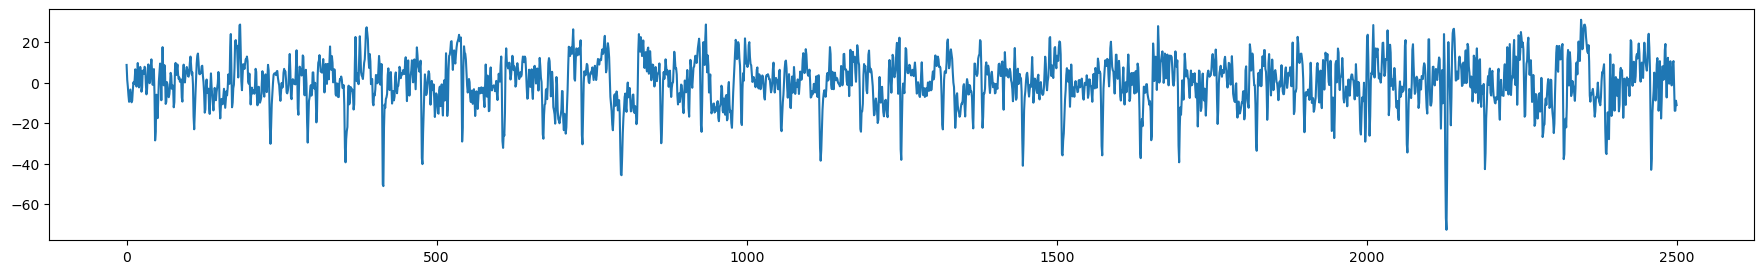

In [39]:
import matplotlib.pyplot as plt
plt.figure(figsize=(22,3))
plt.plot(mist['eeg'][0,0,7,12500:])

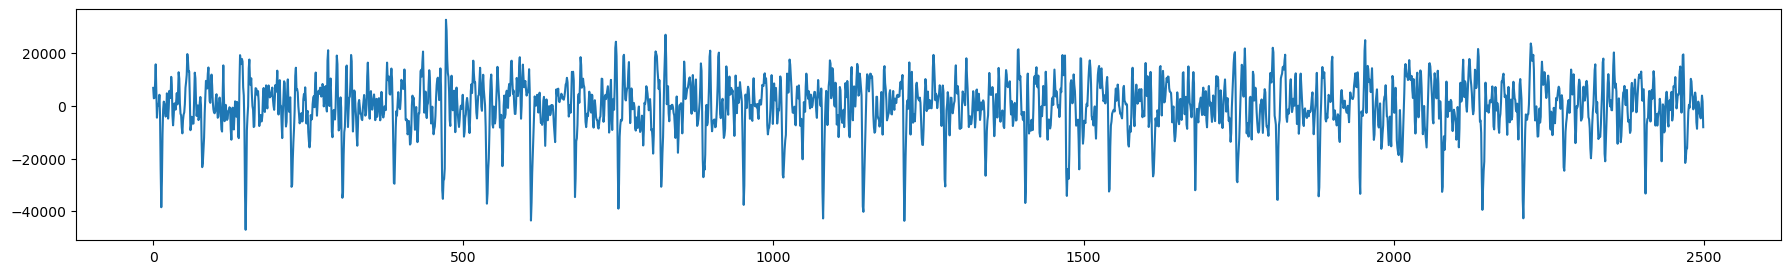

In [40]:
mist = np.load('D:/One_한양대학교/private object minsu/coding/data/samsung_2024/emotion/emotion_data.npy')
plt.figure(figsize=(22,3))
plt.plot(mist[0,0,7,12500:])

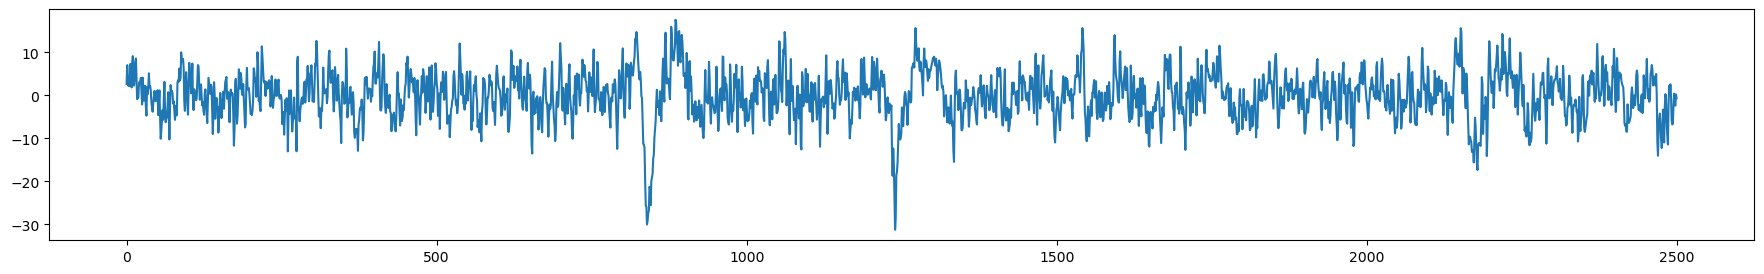

In [41]:
mist = np.load('D:\One_한양대학교\private object minsu\coding\data\samsung_2024\Preprocessed_Stress\Relax\\03.JHS_segment_3.npy')
plt.figure(figsize=(22,3))
plt.plot(mist[7,5000:])